In [1]:
# import the necessary packages

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import seaborn as sns


# DBSCAN algorithm
We perform the density-based clustering using DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm.
It has only two parameters...

- eps: The maximum distance between two samples for them to be considered as in the same neighborhood.
- min_samples: the minimum number of points needed to create a cluster.
... and one output:
- cluster labels for each point in the dataset. Noisy samples are given the label -1.

## Pre-processing
We will use the normalized dataset with Min-Max approach to perform DBSCAN.

<Axes: >

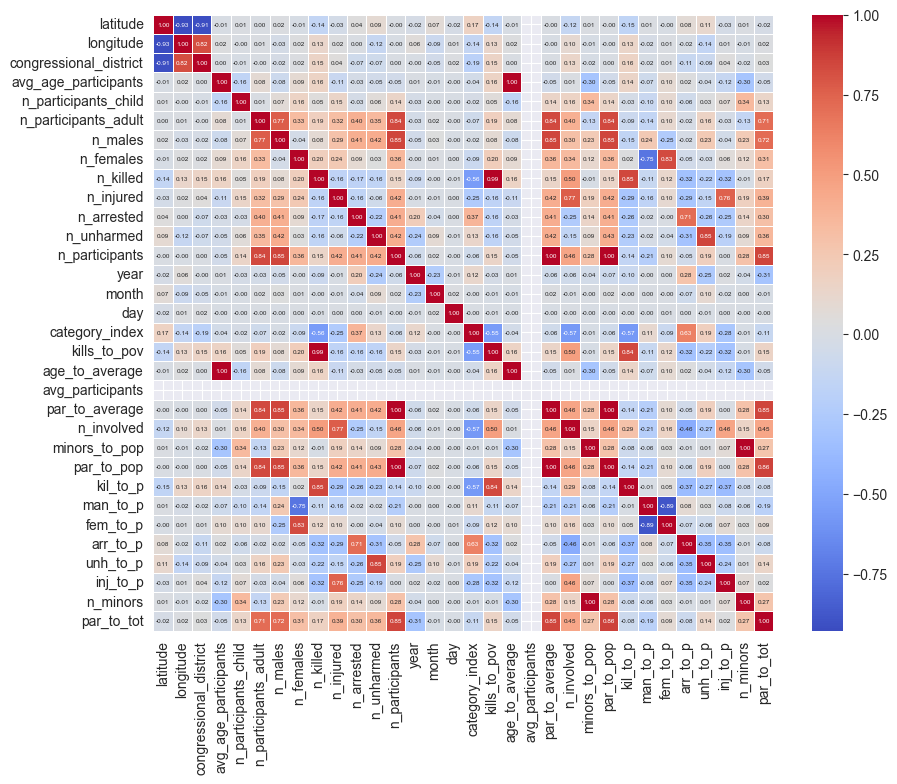

In [2]:
df = pd.read_csv('../data/extracted_features.csv')

standard = StandardScaler()
minmax = MinMaxScaler()

#pick the California data
df = df[df['state'] == 'California']

# plot correlation matrix to see if there is any feature to drop
plt.figure(figsize=(10, 8))
correlation_matrix = df.select_dtypes(include='number').corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, annot_kws={"size": 4.6})

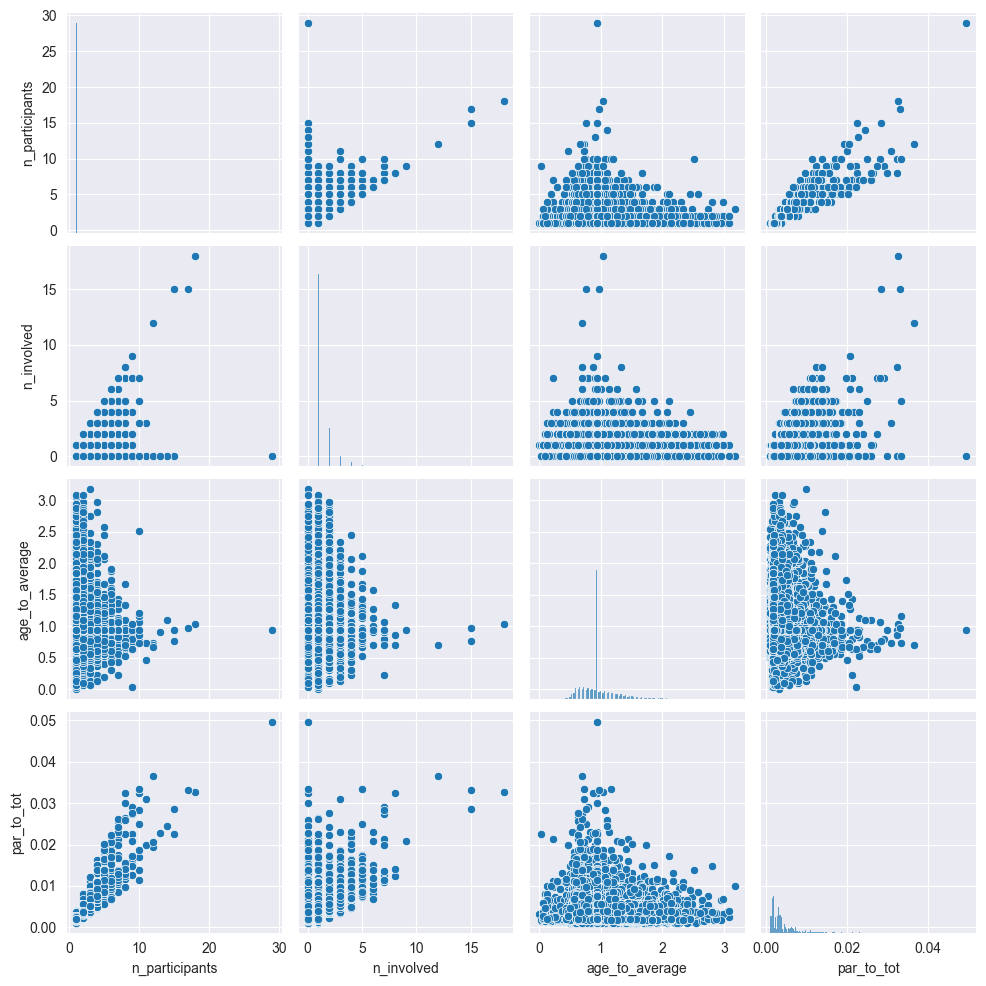

In [3]:
# select only the features that we want to use
new_df = df[['n_participants', 'n_involved', 'age_to_average', 'par_to_tot']].dropna()
sns.pairplot(new_df)

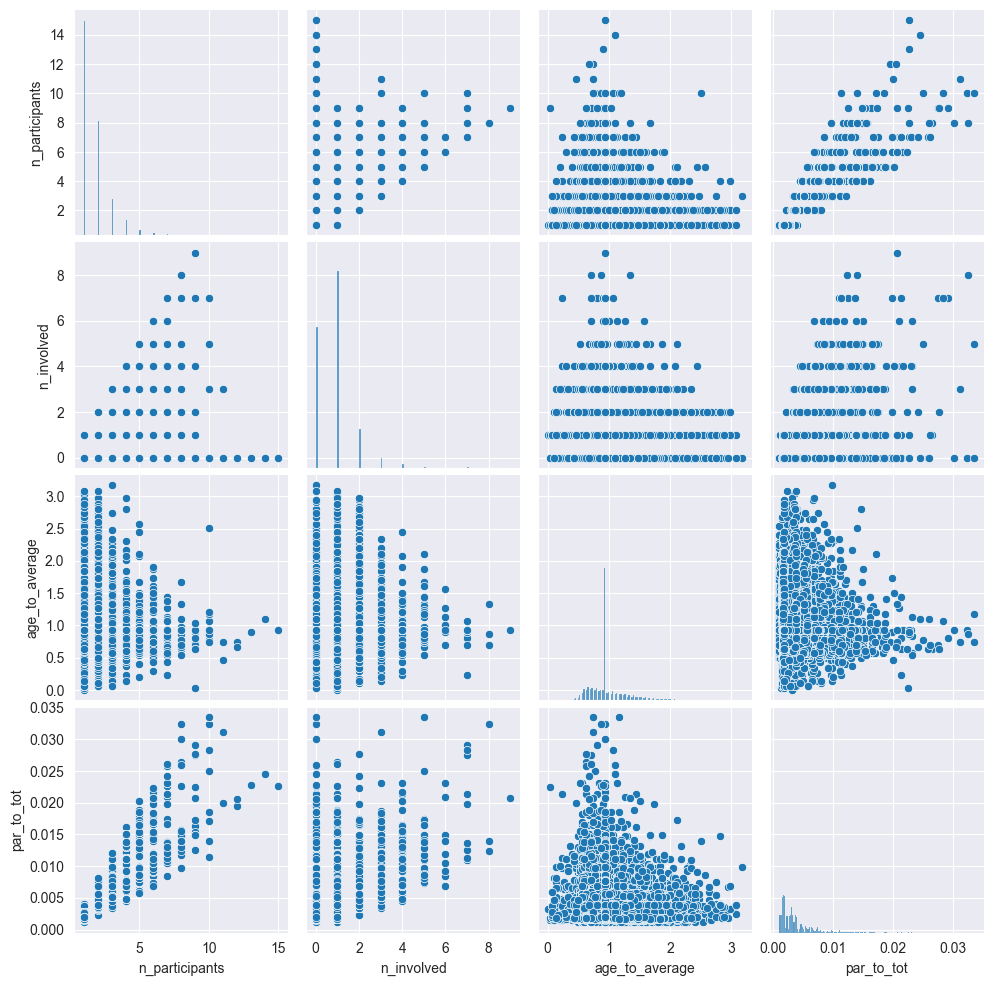

In [4]:
# remove the outlier in california's participants
new_df = new_df[new_df['n_participants'] < 20]
new_df = new_df[new_df['n_involved'] < 10]
sns.pairplot(new_df)

In [5]:
# scale the data
ss_scaled = standard.fit_transform(new_df)
mm_scaled = minmax.fit_transform(new_df)

In [6]:
from scipy.spatial.distance import pdist, squareform
import tqdm


def calc_k_nn_dist_graph(X, ub=0., lb=0.):
    k_list = [3, 5, 9, 15]

    dist = pdist(X, 'euclidean')
    dist = squareform(dist)

    for k in k_list:
        kth_distances = []
        for d in dist:
            index_kth_distance = np.argsort(d)[k]
            kth_distances.append(d[index_kth_distance])

        plt.figure(figsize=(8, 6))
        plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
        plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
        plt.xlabel('sorted distances', fontsize=18)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.grid()
        plt.axhline(ub)
        plt.axhline(lb)
        plt.title('Graph of distance from %sth nearest neighbor' % k)
        plt.show()


In [7]:
# values of min_samples to try
min_samples = range(3, 25, 3)

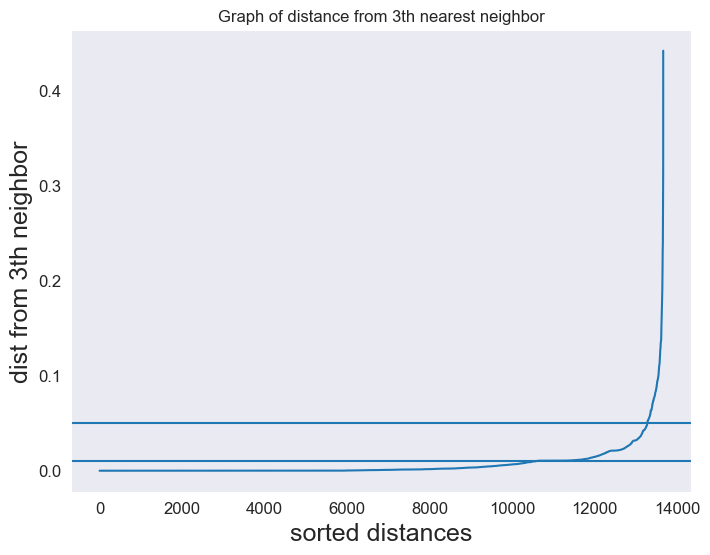

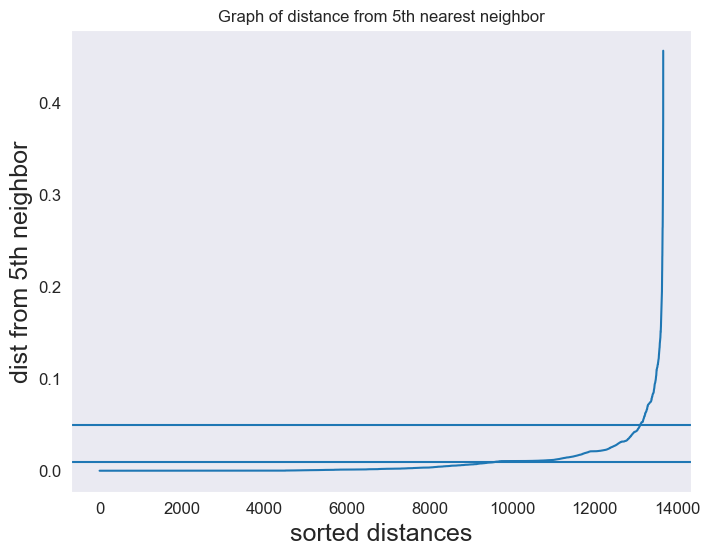

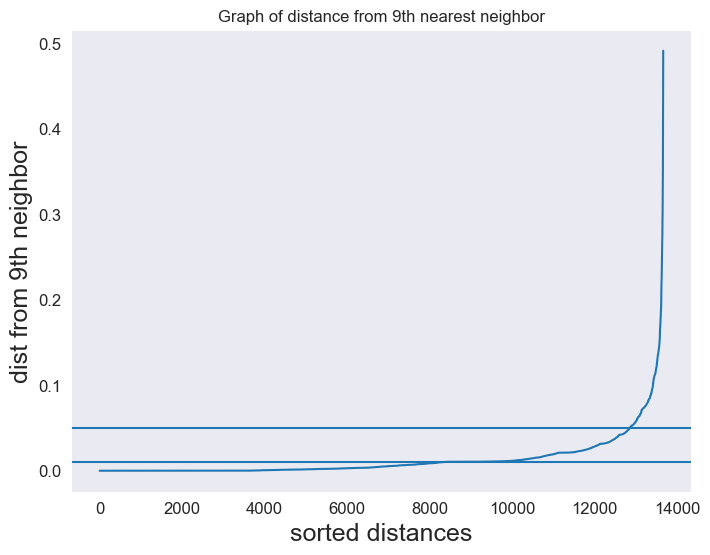

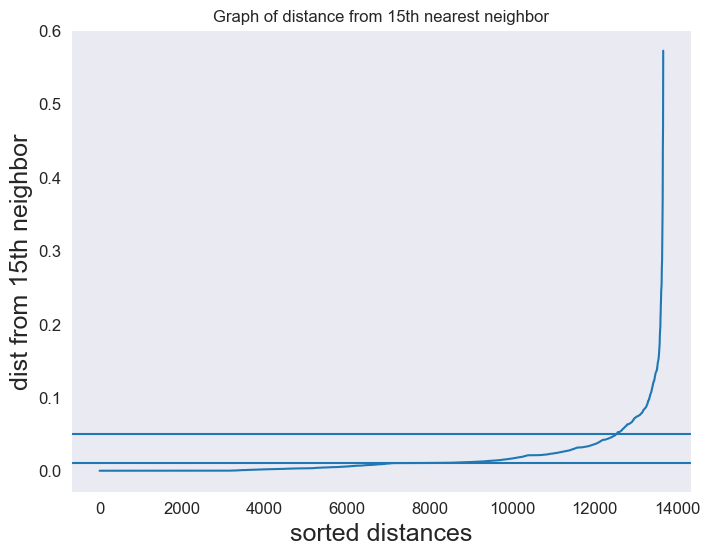

In [8]:
calc_k_nn_dist_graph(mm_scaled, 0.01, 0.1)

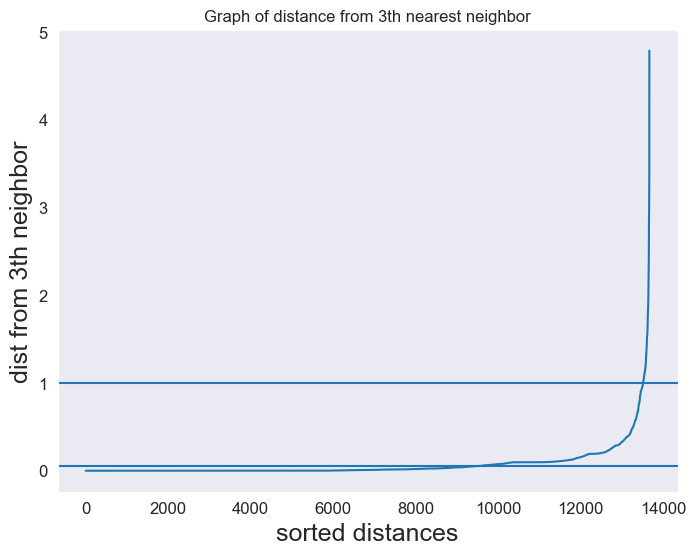

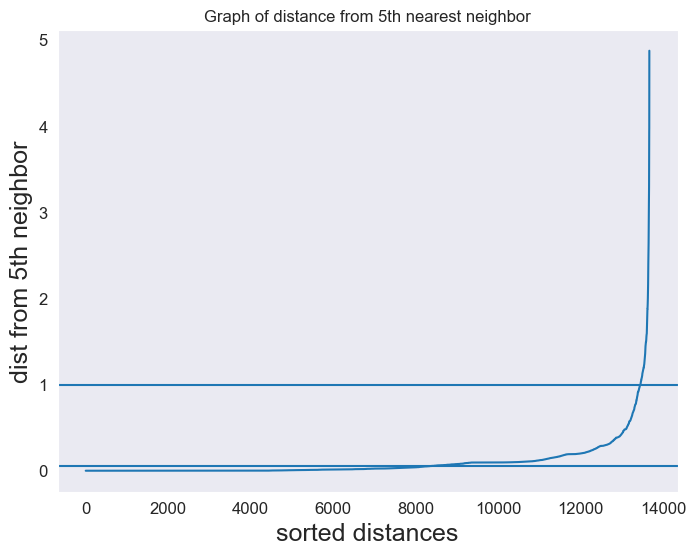

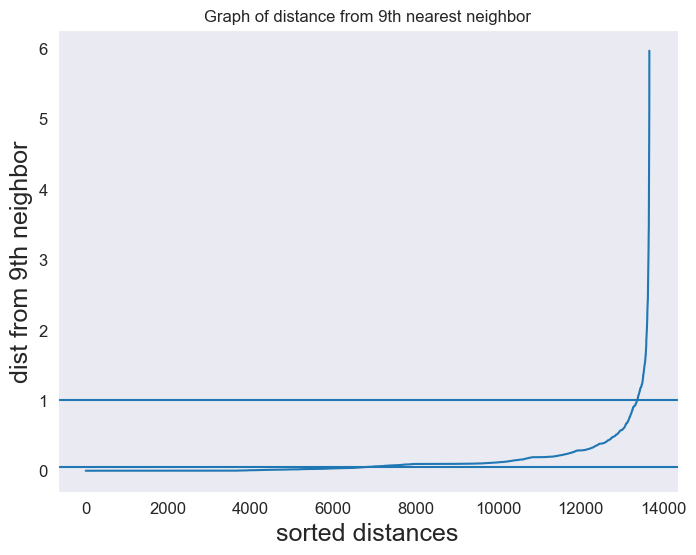

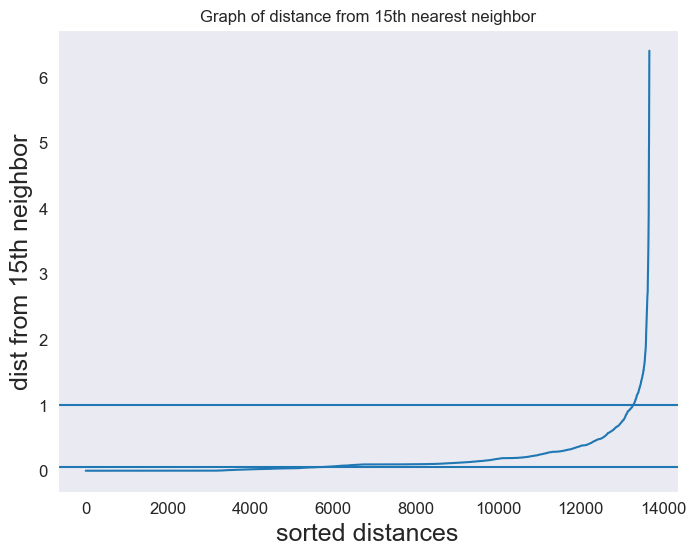

In [9]:
#repeat the same for standard scaled data
calc_k_nn_dist_graph(ss_scaled, 0.05, 1)

In [23]:
def print_best_params(silhouette_scores, parameter_combinations):
    best_score_index = np.argmax(silhouette_scores)  # Get the index of the maximum silhouette score
    best_params = parameter_combinations[best_score_index]  # Retrieve parameters corresponding to the best score

    best_eps, best_min_samples, n_clusters = best_params  # Unpack the best parameters

    best_score = silhouette_scores[best_score_index]  # Get the best silhouette score

    # Print the best silhouette score and corresponding parameters
    print(f"Best Silhouette Score: {best_score}")
    print(f"Best Parameters - eps: {best_eps}, min_samples: {best_min_samples}", f"Number of clusters: {n_clusters}")
    return best_eps, best_min_samples

# MinMax Scaling Test

In [11]:
mm_eps_values = np.arange(0.05, 0.105, 0.005)

In [12]:
# test the best parameters for the DBSCAN algorithm
silhouette_scores = []
parameter_combinations = []

best_score = -1  # Initialize best silhouette score
best_params = {'eps': None, 'min_samples': None, 'n_clusters': None}
for eps in mm_eps_values:
    for min_sample in min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        labels = dbscan.fit_predict(mm_scaled)

        unique_labels = np.unique(labels)
        if len(unique_labels) < 3: continue
        silhouette = silhouette_score(mm_scaled, labels)
        print(
            f"Number of clusters: {len(unique_labels)}, eps: {eps}, min_samples: {min_sample} , Silhouette score: {silhouette}")
        silhouette_scores.append(silhouette)
        parameter_combinations.append((eps, min_sample, len(unique_labels)))

# Plotting the results
silhouette_scores = np.array(silhouette_scores)
parameter_combinations = np.array(parameter_combinations)


Number of clusters: 52, eps: 0.05, min_samples: 3 , Silhouette score: 0.18006873866799775
Number of clusters: 27, eps: 0.05, min_samples: 6 , Silhouette score: 0.18737898991257934
Number of clusters: 21, eps: 0.05, min_samples: 9 , Silhouette score: 0.21285882203614714
Number of clusters: 23, eps: 0.05, min_samples: 12 , Silhouette score: 0.20142216889344602
Number of clusters: 19, eps: 0.05, min_samples: 15 , Silhouette score: 0.20057046154885014
Number of clusters: 15, eps: 0.05, min_samples: 18 , Silhouette score: 0.2077897646725675
Number of clusters: 15, eps: 0.05, min_samples: 21 , Silhouette score: 0.18783039688674247
Number of clusters: 16, eps: 0.05, min_samples: 24 , Silhouette score: 0.18191860849642646
Number of clusters: 46, eps: 0.055, min_samples: 3 , Silhouette score: 0.19325896908200338
Number of clusters: 26, eps: 0.055, min_samples: 6 , Silhouette score: 0.19009989207371605
Number of clusters: 21, eps: 0.055, min_samples: 9 , Silhouette score: 0.21160484878765598
Num

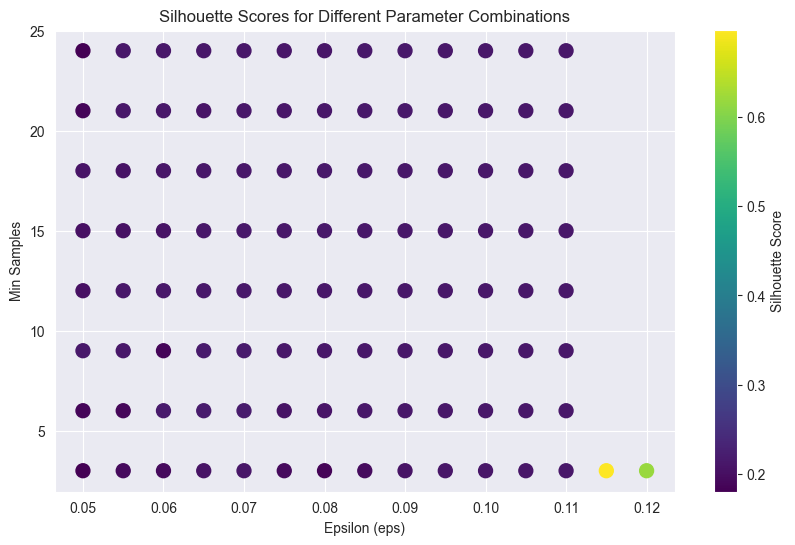

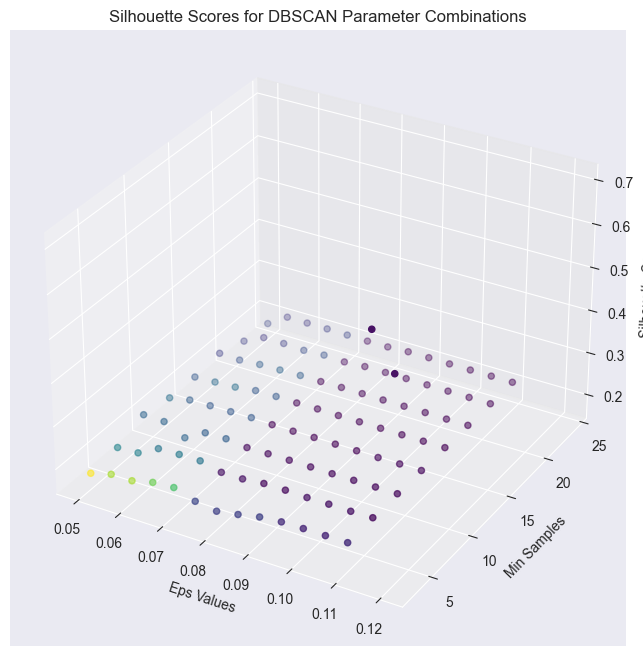

Best Silhouette Score: 0.697713394296651
Best Parameters - eps: 0.11499999999999998, min_samples: 3.0 Number of clusters: 8.0


In [13]:
eps_values = parameter_combinations[:, 0]
min_samples_values = parameter_combinations[:, 1]
n_clusters = parameter_combinations[:, 2]

plt.figure(figsize=(10, 6))
plt.scatter(eps_values, min_samples_values, c=silhouette_scores, cmap='viridis', s=100)
plt.colorbar(label='Silhouette Score')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Min Samples')
plt.title('Silhouette Scores for Different Parameter Combinations')
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(eps_values, min_samples_values, silhouette_scores, c=n_clusters, cmap='viridis')
ax.set_xlabel('Eps Values')
ax.set_ylabel('Min Samples')
ax.set_zlabel('Silhouette Score')
ax.set_title('Silhouette Scores for DBSCAN Parameter Combinations')

plt.show()

best_eps, best_min_samples = print_best_params(silhouette_scores, parameter_combinations)

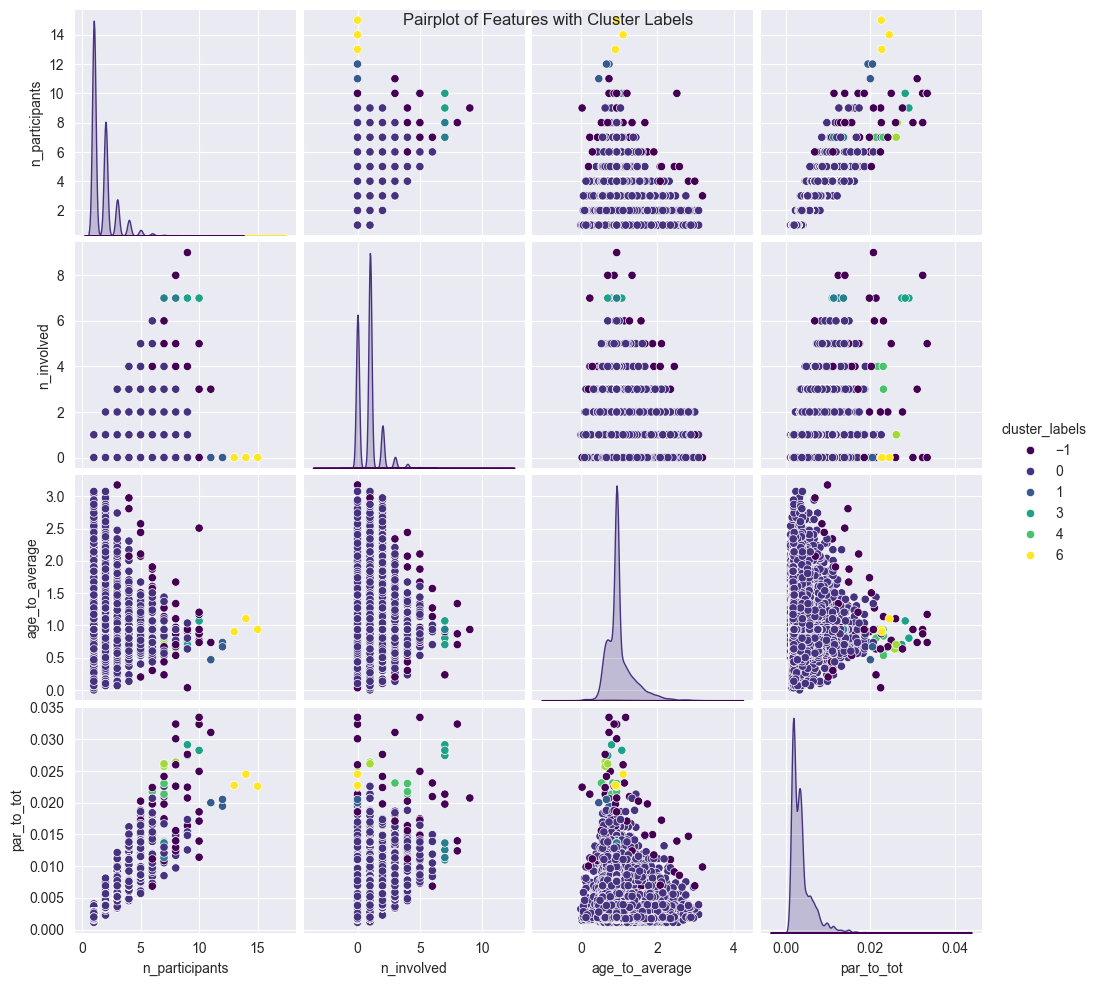

cluster_labels
 0    13593
-1       49
 4        6
 2        5
 1        3
 5        3
 3        3
 6        3
Name: count, dtype: int64

In [14]:
dbscan = DBSCAN(eps=best_eps, min_samples=int(best_min_samples))
cluster_labels = dbscan.fit_predict(mm_scaled)
selected_data = new_df.copy()
selected_data['cluster_labels'] = cluster_labels
#selected_data = selected_data[selected_data['cluster_labels'] != -1]
sns.pairplot(selected_data, hue='cluster_labels', palette='viridis')
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()
selected_data['cluster_labels'].value_counts()

0.21268455095050168


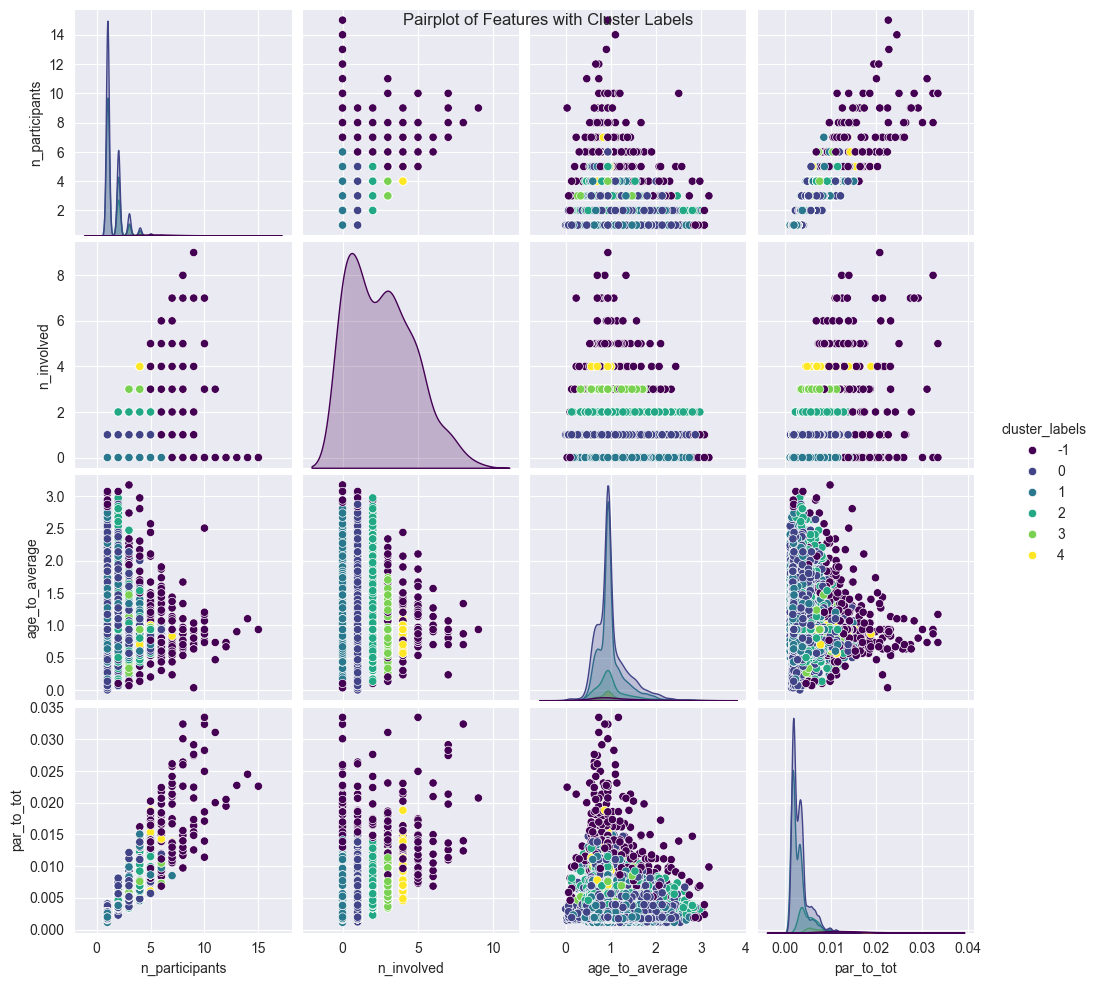

cluster_labels
 0    6805
 1    4850
 2    1323
 3     308
-1     274
 4     105
Name: count, dtype: int64

In [16]:
dbscan = DBSCAN(eps=0.08, min_samples=15)
cluster_labels = dbscan.fit_predict(mm_scaled)
selected_data = new_df.copy()
selected_data['cluster_labels'] = cluster_labels
print(silhouette_score(mm_scaled, cluster_labels))
#selected_data = selected_data[selected_data['cluster_labels'] != -1]
sns.pairplot(selected_data, hue='cluster_labels', palette='viridis')
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()
selected_data['cluster_labels'].value_counts()


Cluster 0
       n_participants  n_involved  age_to_average  par_to_tot  cluster_labels
12356               1           1        0.635334    0.001621               0
12358               1           1        0.936282    0.001621               0
12359               4           1        0.601896    0.007812               0
12360               1           1        0.902843    0.001395               0
12362               3           1        1.036598    0.004862               0


Cluster 1
       n_participants  n_involved  age_to_average  par_to_tot  cluster_labels
12357               1           0        0.936282    0.001621               1
12361               1           0        1.437862    0.001395               1
12366               1           0        1.170352    0.001621               1
12369               1           0        0.702211    0.001395               1
12371               1           0        0.936282    0.001953               1


Cluster 2
       n_participants  n_invol

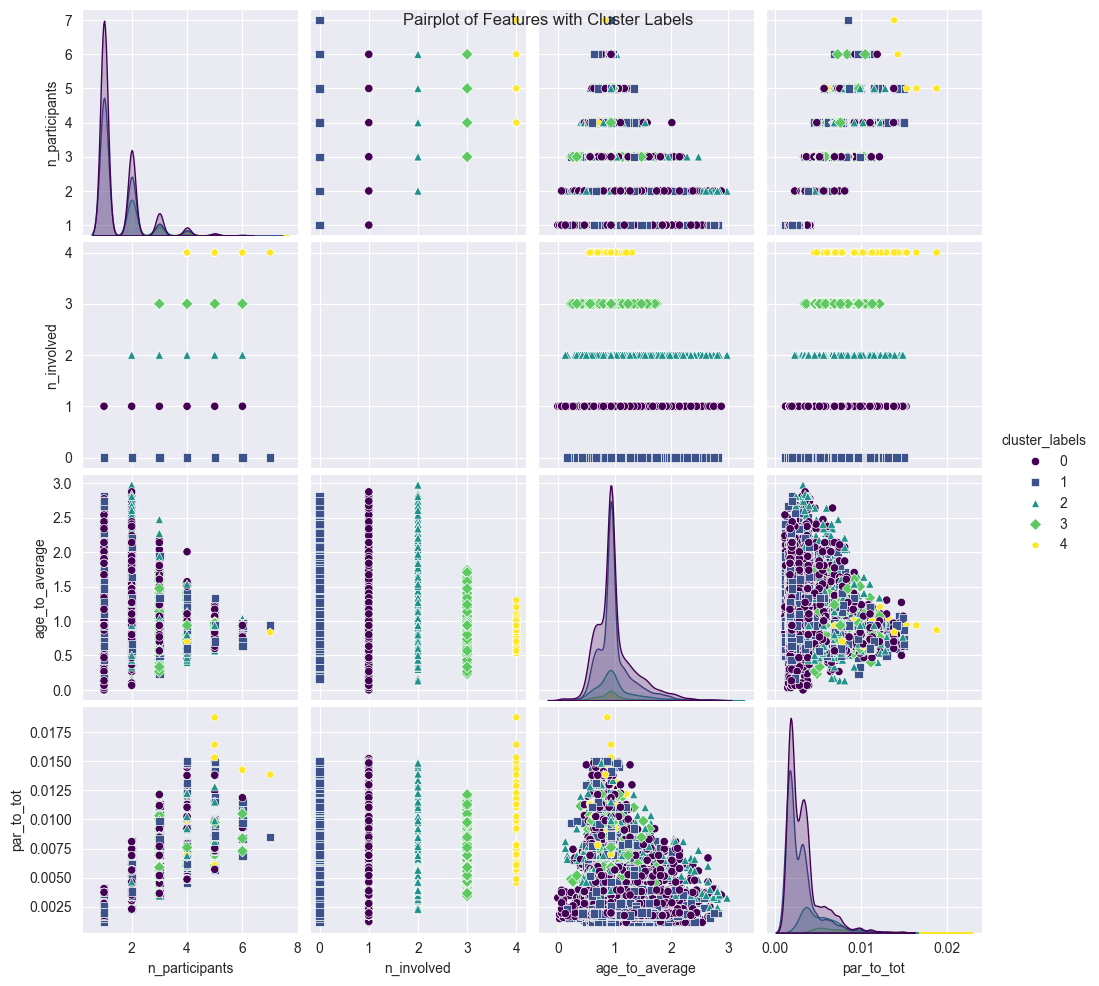

cluster_labels
0    6805
1    4850
2    1323
3     308
4     105
Name: count, dtype: int64

In [19]:
# print examples for each cluster
for i in selected_data['cluster_labels'].unique():
    print(f"Cluster {i}")
    print(selected_data[selected_data['cluster_labels'] == i].head())
    print("\n")

selected_data = selected_data[selected_data['cluster_labels'] != -1]
sns.pairplot(selected_data, hue='cluster_labels', palette='viridis', markers=['o', 's', '^', 'D', 'p'])
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()
selected_data['cluster_labels'].value_counts()

# Standard Scaling Test

In [20]:
ss_eps_values = np.linspace(0.1, 1.0, 10)

In [21]:
silhouette_scores = []
parameter_combinations = []

best_score = -1  # Initialize best silhouette score
best_params = {'eps': None, 'min_samples': None}

for eps in ss_eps_values:
    for min_sample in min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        labels = dbscan.fit_predict(ss_scaled)

        unique_labels = np.unique(labels)
        if len(unique_labels) < 4 or len(unique_labels) > 50: continue
        silhouette = silhouette_score(ss_scaled, labels)
        print(
            f"Number of clusters: {len(unique_labels)}, eps: {eps}, min_samples: {min_sample} , Silhouette score: {silhouette}")
        silhouette_scores.append(silhouette)
        parameter_combinations.append((eps, min_sample, len(unique_labels)))

# Plotting the results
silhouette_scores = np.array(silhouette_scores)
parameter_combinations = np.array(parameter_combinations)


Number of clusters: 48, eps: 0.1, min_samples: 15 , Silhouette score: -0.13177716013104065
Number of clusters: 36, eps: 0.1, min_samples: 18 , Silhouette score: -0.12240663714777898
Number of clusters: 34, eps: 0.1, min_samples: 21 , Silhouette score: -0.1617244398672471
Number of clusters: 36, eps: 0.1, min_samples: 24 , Silhouette score: -0.21571869905381338
Number of clusters: 43, eps: 0.2, min_samples: 9 , Silhouette score: 0.16743101596729934
Number of clusters: 25, eps: 0.2, min_samples: 12 , Silhouette score: 0.12643059968048181
Number of clusters: 27, eps: 0.2, min_samples: 15 , Silhouette score: 0.1456535988460099
Number of clusters: 18, eps: 0.2, min_samples: 18 , Silhouette score: 0.12465814798819605
Number of clusters: 17, eps: 0.2, min_samples: 21 , Silhouette score: 0.12425147021058972
Number of clusters: 16, eps: 0.2, min_samples: 24 , Silhouette score: 0.15337324082036854
Number of clusters: 44, eps: 0.30000000000000004, min_samples: 6 , Silhouette score: 0.211473335806

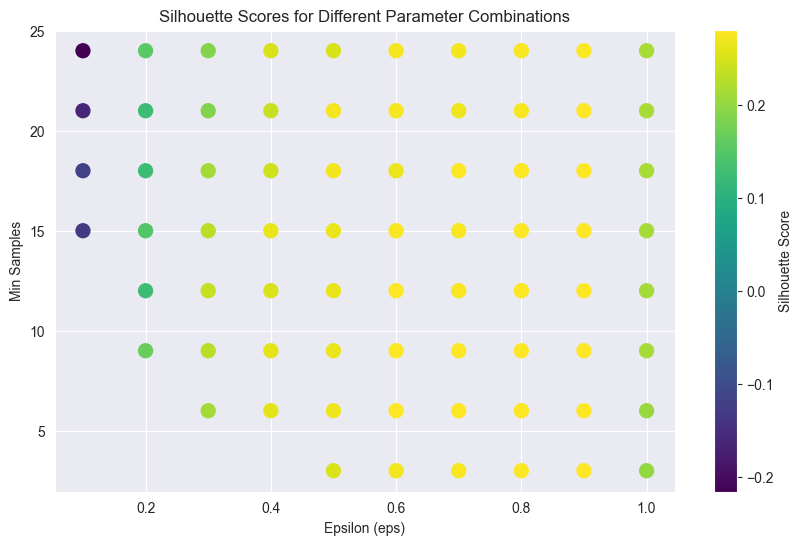

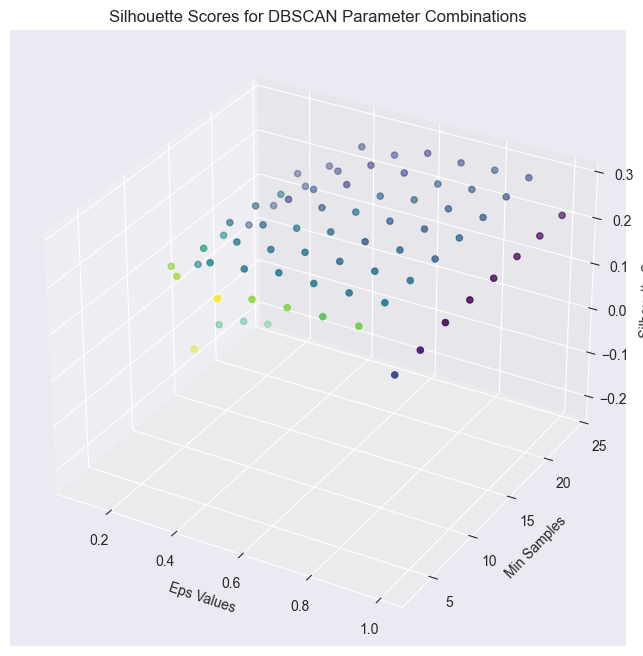

Best Silhouette Score: 0.2803620632171475
Best Parameters - eps: 0.6, min_samples: 6.0 Number of clusters: 24.0


In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(parameter_combinations[:, 0], parameter_combinations[:, 1], c=silhouette_scores, cmap='viridis', s=100)
plt.colorbar(label='Silhouette Score')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Min Samples')
plt.title('Silhouette Scores for Different Parameter Combinations')
plt.grid(True)
plt.show()

eps_values = parameter_combinations[:, 0]
min_samples_values = parameter_combinations[:, 1]
clusters = parameter_combinations[:, 2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(eps_values, min_samples_values, silhouette_scores, c=clusters, cmap='viridis')
ax.set_xlabel('Eps Values')
ax.set_ylabel('Min Samples')
ax.set_zlabel('Silhouette Score')
ax.set_title('Silhouette Scores for DBSCAN Parameter Combinations')

plt.show()

best_eps, best_min_samples = print_best_params(silhouette_scores, parameter_combinations)

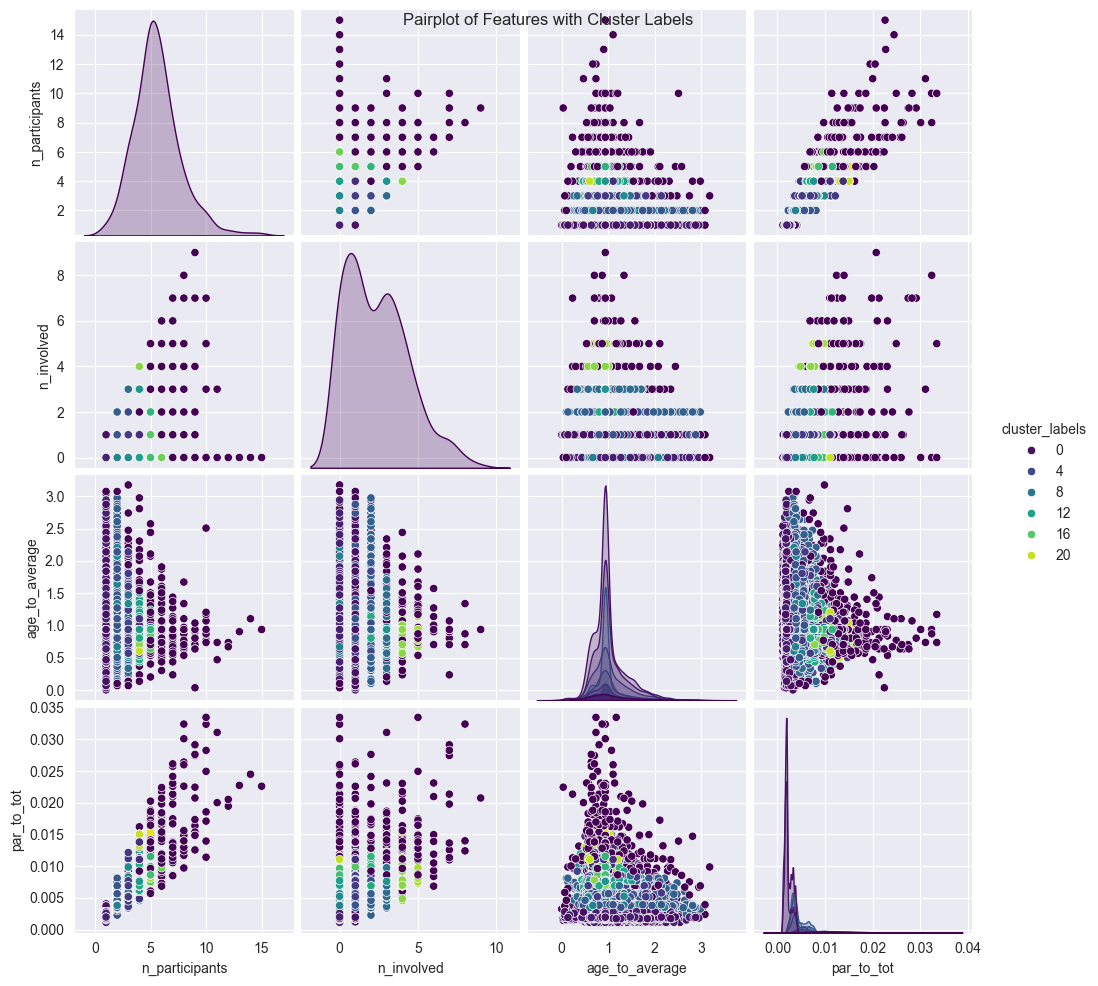

cluster_labels
 0     4395
 1     3097
 5     1743
 9     1321
 6      920
 3      454
-1      330
 4      273
 10     262
 7      242
 2      160
 13     106
 12      85
 18      75
 11      40
 20      36
 16      33
 15      25
 21      18
 14      15
 8       13
 19       9
 17       8
 22       5
Name: count, dtype: int64

In [26]:
dbscan = DBSCAN(eps=best_eps, min_samples=int(best_min_samples))
cluster_labels = dbscan.fit_predict(ss_scaled)
selected_data = new_df.copy()
selected_data['cluster_labels'] = cluster_labels
#selected_data = selected_data[selected_data['cluster_labels'] != -1]
sns.pairplot(selected_data, hue='cluster_labels', palette='viridis')
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()

#count size of each cluster
selected_data['cluster_labels'].value_counts()

0.273823824485308


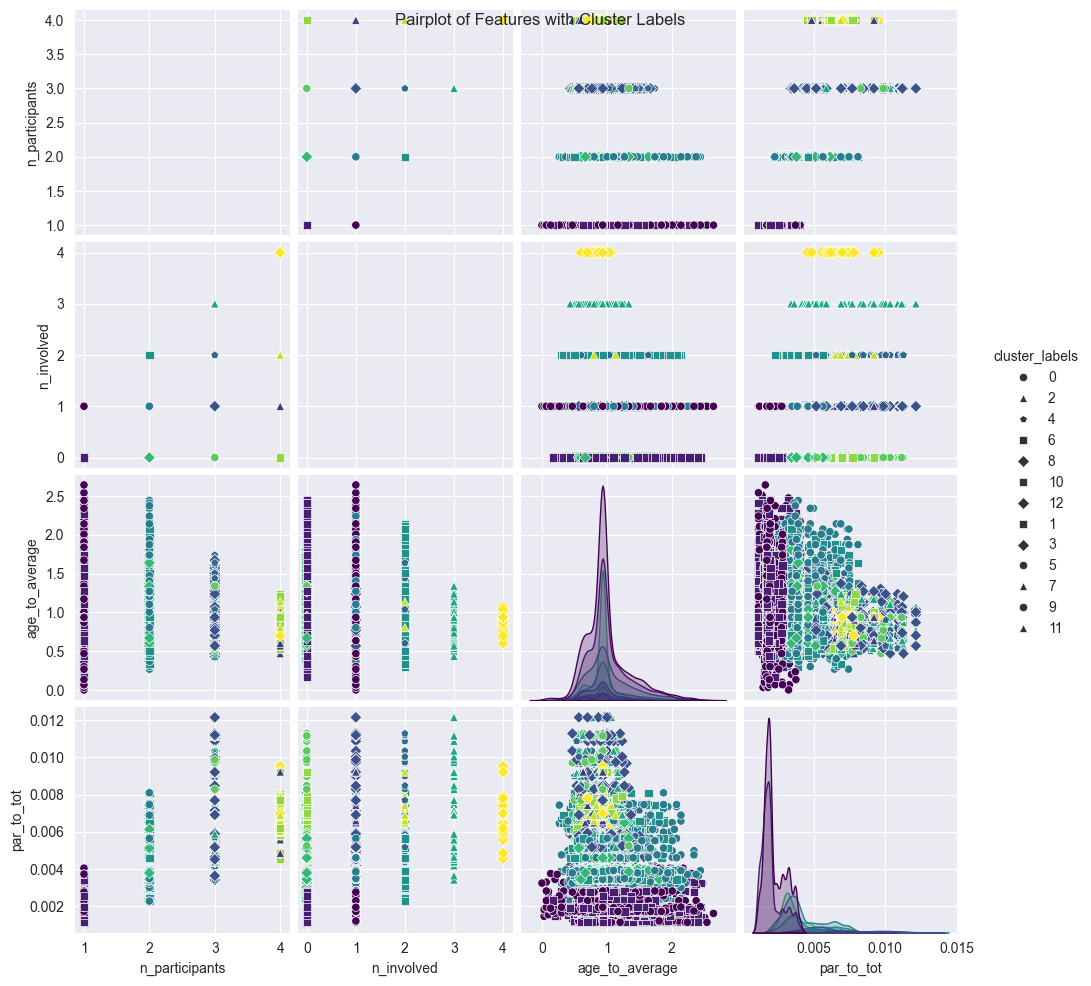

cluster_labels
0     4389
1     3089
5     1726
8     1300
6      863
3      435
9      260
4      237
7      220
2      110
10      78
11      56
12      45
Name: count, dtype: int64

In [30]:
dbscan = DBSCAN(eps=0.6, min_samples=24)
cluster_labels = dbscan.fit_predict(ss_scaled)
print(silhouette_score(ss_scaled, cluster_labels))
selected_data = new_df.copy()
selected_data['cluster_labels'] = cluster_labels
selected_data = selected_data[selected_data['cluster_labels'] != -1]
sns.pairplot(selected_data, hue='cluster_labels', palette='viridis',
             markers=['o', 's', '^', 'D', 'p', 'o', 's', '^', 'D', 'o', 's', '^', 'D'])
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()

#count size of each cluster
selected_data['cluster_labels'].value_counts()

0.21522521919512194


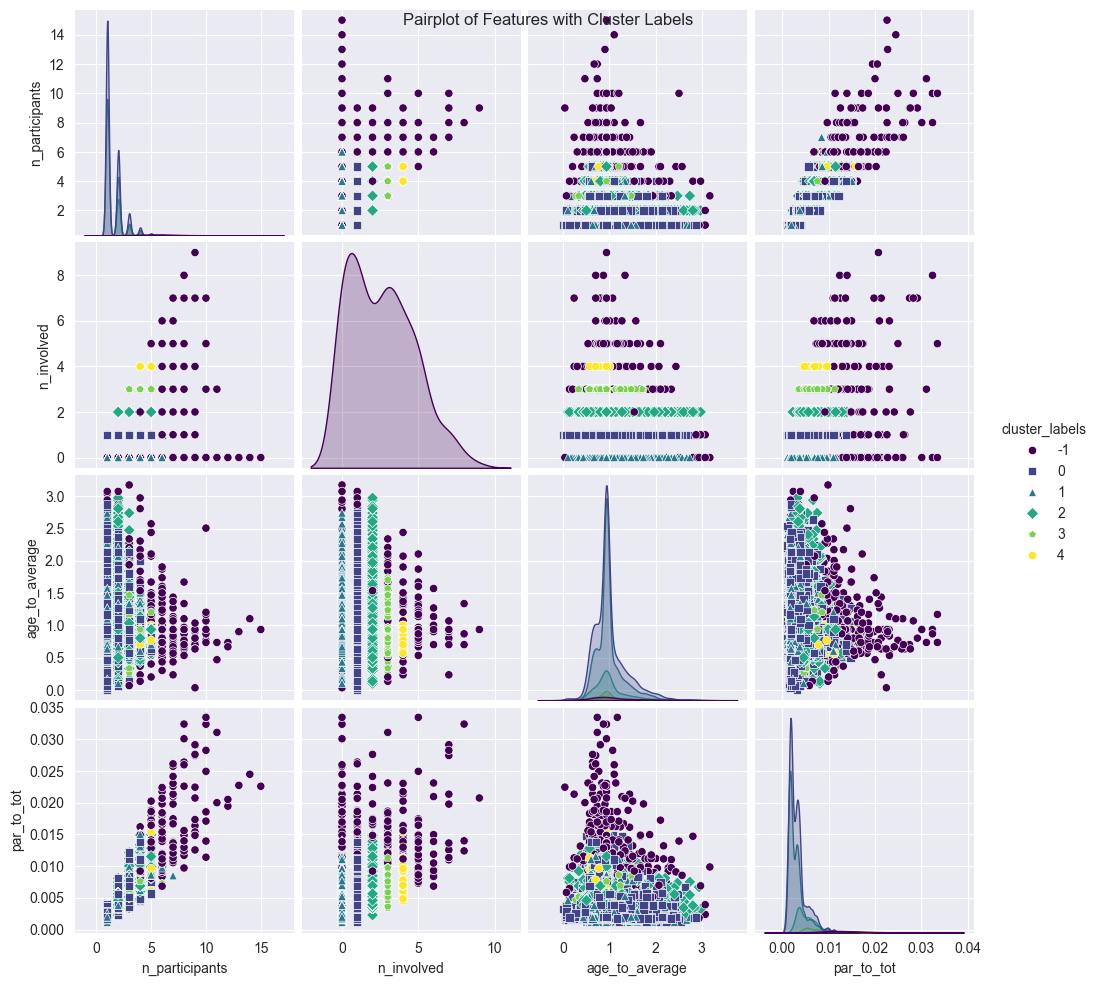

cluster_labels
 0    6805
 1    4851
 2    1324
 3     308
-1     275
 4     102
Name: count, dtype: int64

In [32]:
dbscan = DBSCAN(eps=1.0, min_samples=24)
cluster_labels = dbscan.fit_predict(ss_scaled)
print(silhouette_score(ss_scaled, cluster_labels))
selected_data = new_df.copy()
selected_data['cluster_labels'] = cluster_labels
#selected_data = selected_data[selected_data['cluster_labels'] != -1]
sns.pairplot(selected_data, hue='cluster_labels', palette='viridis',
             markers=['o', 's', '^', 'D', 'p', 'o'])
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()

#count size of each cluster
selected_data['cluster_labels'].value_counts()

In [33]:
# print examples for each cluster
for i in selected_data['cluster_labels'].unique():
    print(f"Cluster {i}")
    print(selected_data[selected_data['cluster_labels'] == i].head())
    print("\n")

Cluster 0
       n_participants  n_involved  age_to_average  par_to_tot  cluster_labels
12356               1           1        0.635334    0.001621               0
12358               1           1        0.936282    0.001621               0
12359               4           1        0.601896    0.007812               0
12360               1           1        0.902843    0.001395               0
12362               3           1        1.036598    0.004862               0


Cluster 1
       n_participants  n_involved  age_to_average  par_to_tot  cluster_labels
12357               1           0        0.936282    0.001621               1
12361               1           0        1.437862    0.001395               1
12366               1           0        1.170352    0.001621               1
12369               1           0        0.702211    0.001395               1
12371               1           0        0.936282    0.001953               1


Cluster 2
       n_participants  n_invol